In [1]:
# importamos as libs
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import os
import random

In [2]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"

N_STATES=27

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%",
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [4]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [5]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


In [6]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=LABELS)

    plt.show()

In [8]:
# n_steps -> timestep no tempo .. pegar contexto
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [127]:
class StandardScaler3DShape:
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() #StandardScaler()

    def fit_transform(self, X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

    def fit(self, X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self

    def transform(self, X, y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

In [26]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [28]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

## Ler dados e df de erro

In [86]:
x = pd.read_csv(PATH+"input.csv")

x= pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x = x.drop(["data"], axis=1)

y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

In [87]:
df = x.copy()
df["consumo"] = y


## Modelo

In [121]:
df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

timesteps=3
scaler = StandardScaler3DShape()
x_train,y_train = split_sequences(df_train.values, timesteps)
x_test,y_test = split_sequences(df_test.values, timesteps)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [122]:
model = Sequential()
model.add(LSTM(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


In [123]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
250/250 [==============================] - 3s 7ms/step - loss: 7842970992640.0000 - RMSE: 2800530.5000
Epoch 2/100
250/250 [==============================] - 2s 6ms/step - loss: 6412331122688.0000 - RMSE: 2532258.0000
Epoch 3/100
250/250 [==============================] - 2s 10ms/step - loss: 4858982694912.0000 - RMSE: 2204310.0000
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 2677160017920.0000 - RMSE: 1636202.8750
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 1134098382848.0000 - RMSE: 1064940.5000
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 1021378822144.0000 - RMSE: 1010632.8750
Epoch 7/100
250/250 [==============================] - 2s 7ms/step - loss: 866994814976.0000 - RMSE: 931125.5625
Epoch 8/100
250/250 [==============================] - 2s 8ms/step - loss: 807587217408.0000 - RMSE: 898658.5625
Epoch 9/100
250/250 [==============================] - 2s 6ms/step - loss: 88742343

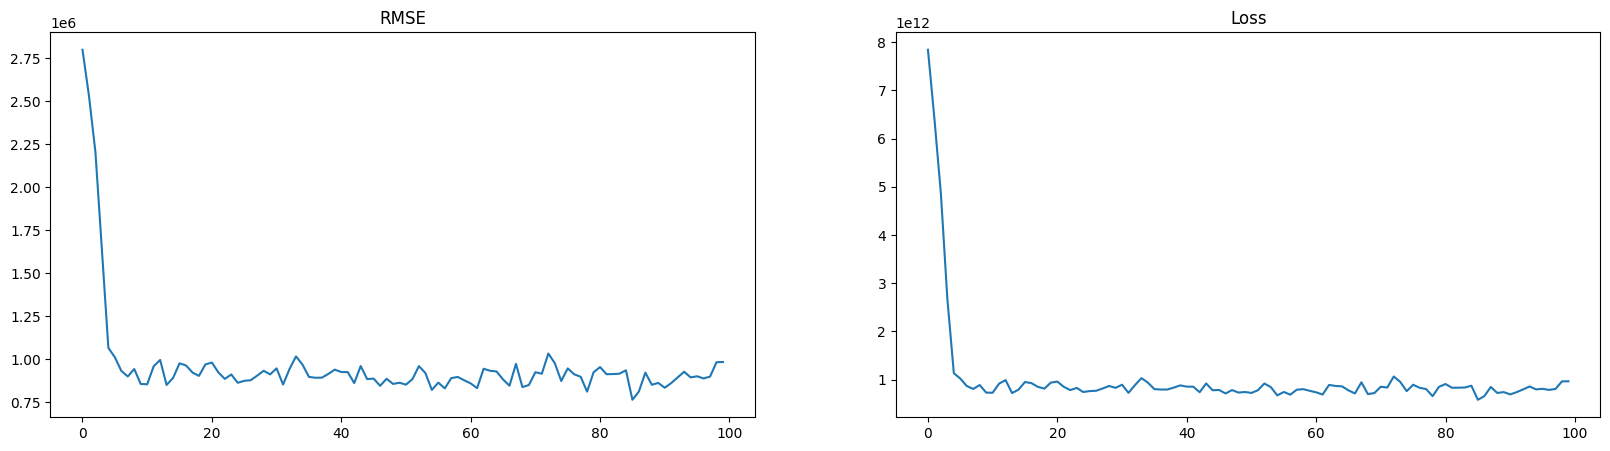

In [124]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [125]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

44/44 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 724346.765316931
MAE: 405718.8906028054
MAPE: 0.34073550316397516


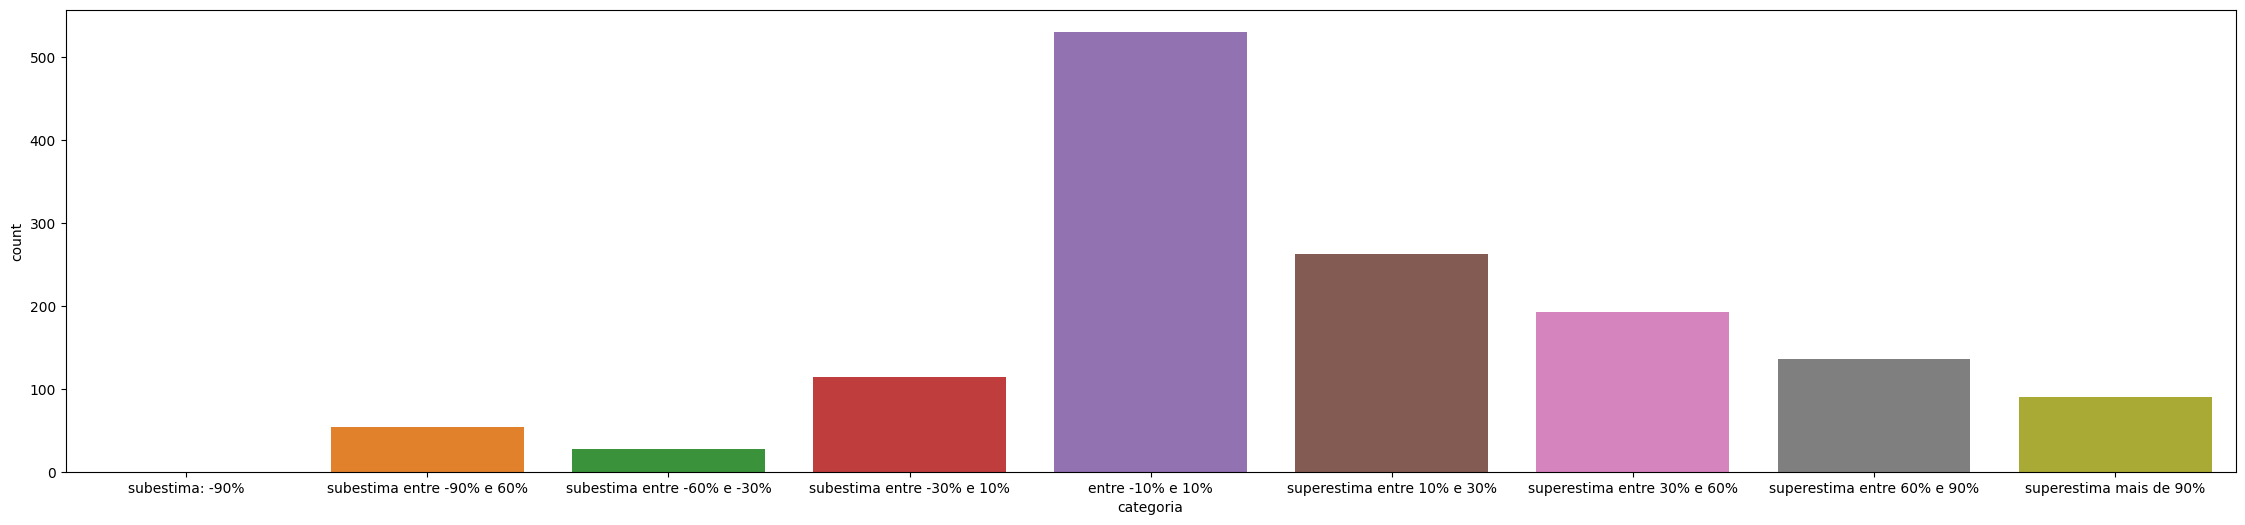

In [126]:
show_delta(np.array(y_test), y_pred.flatten())

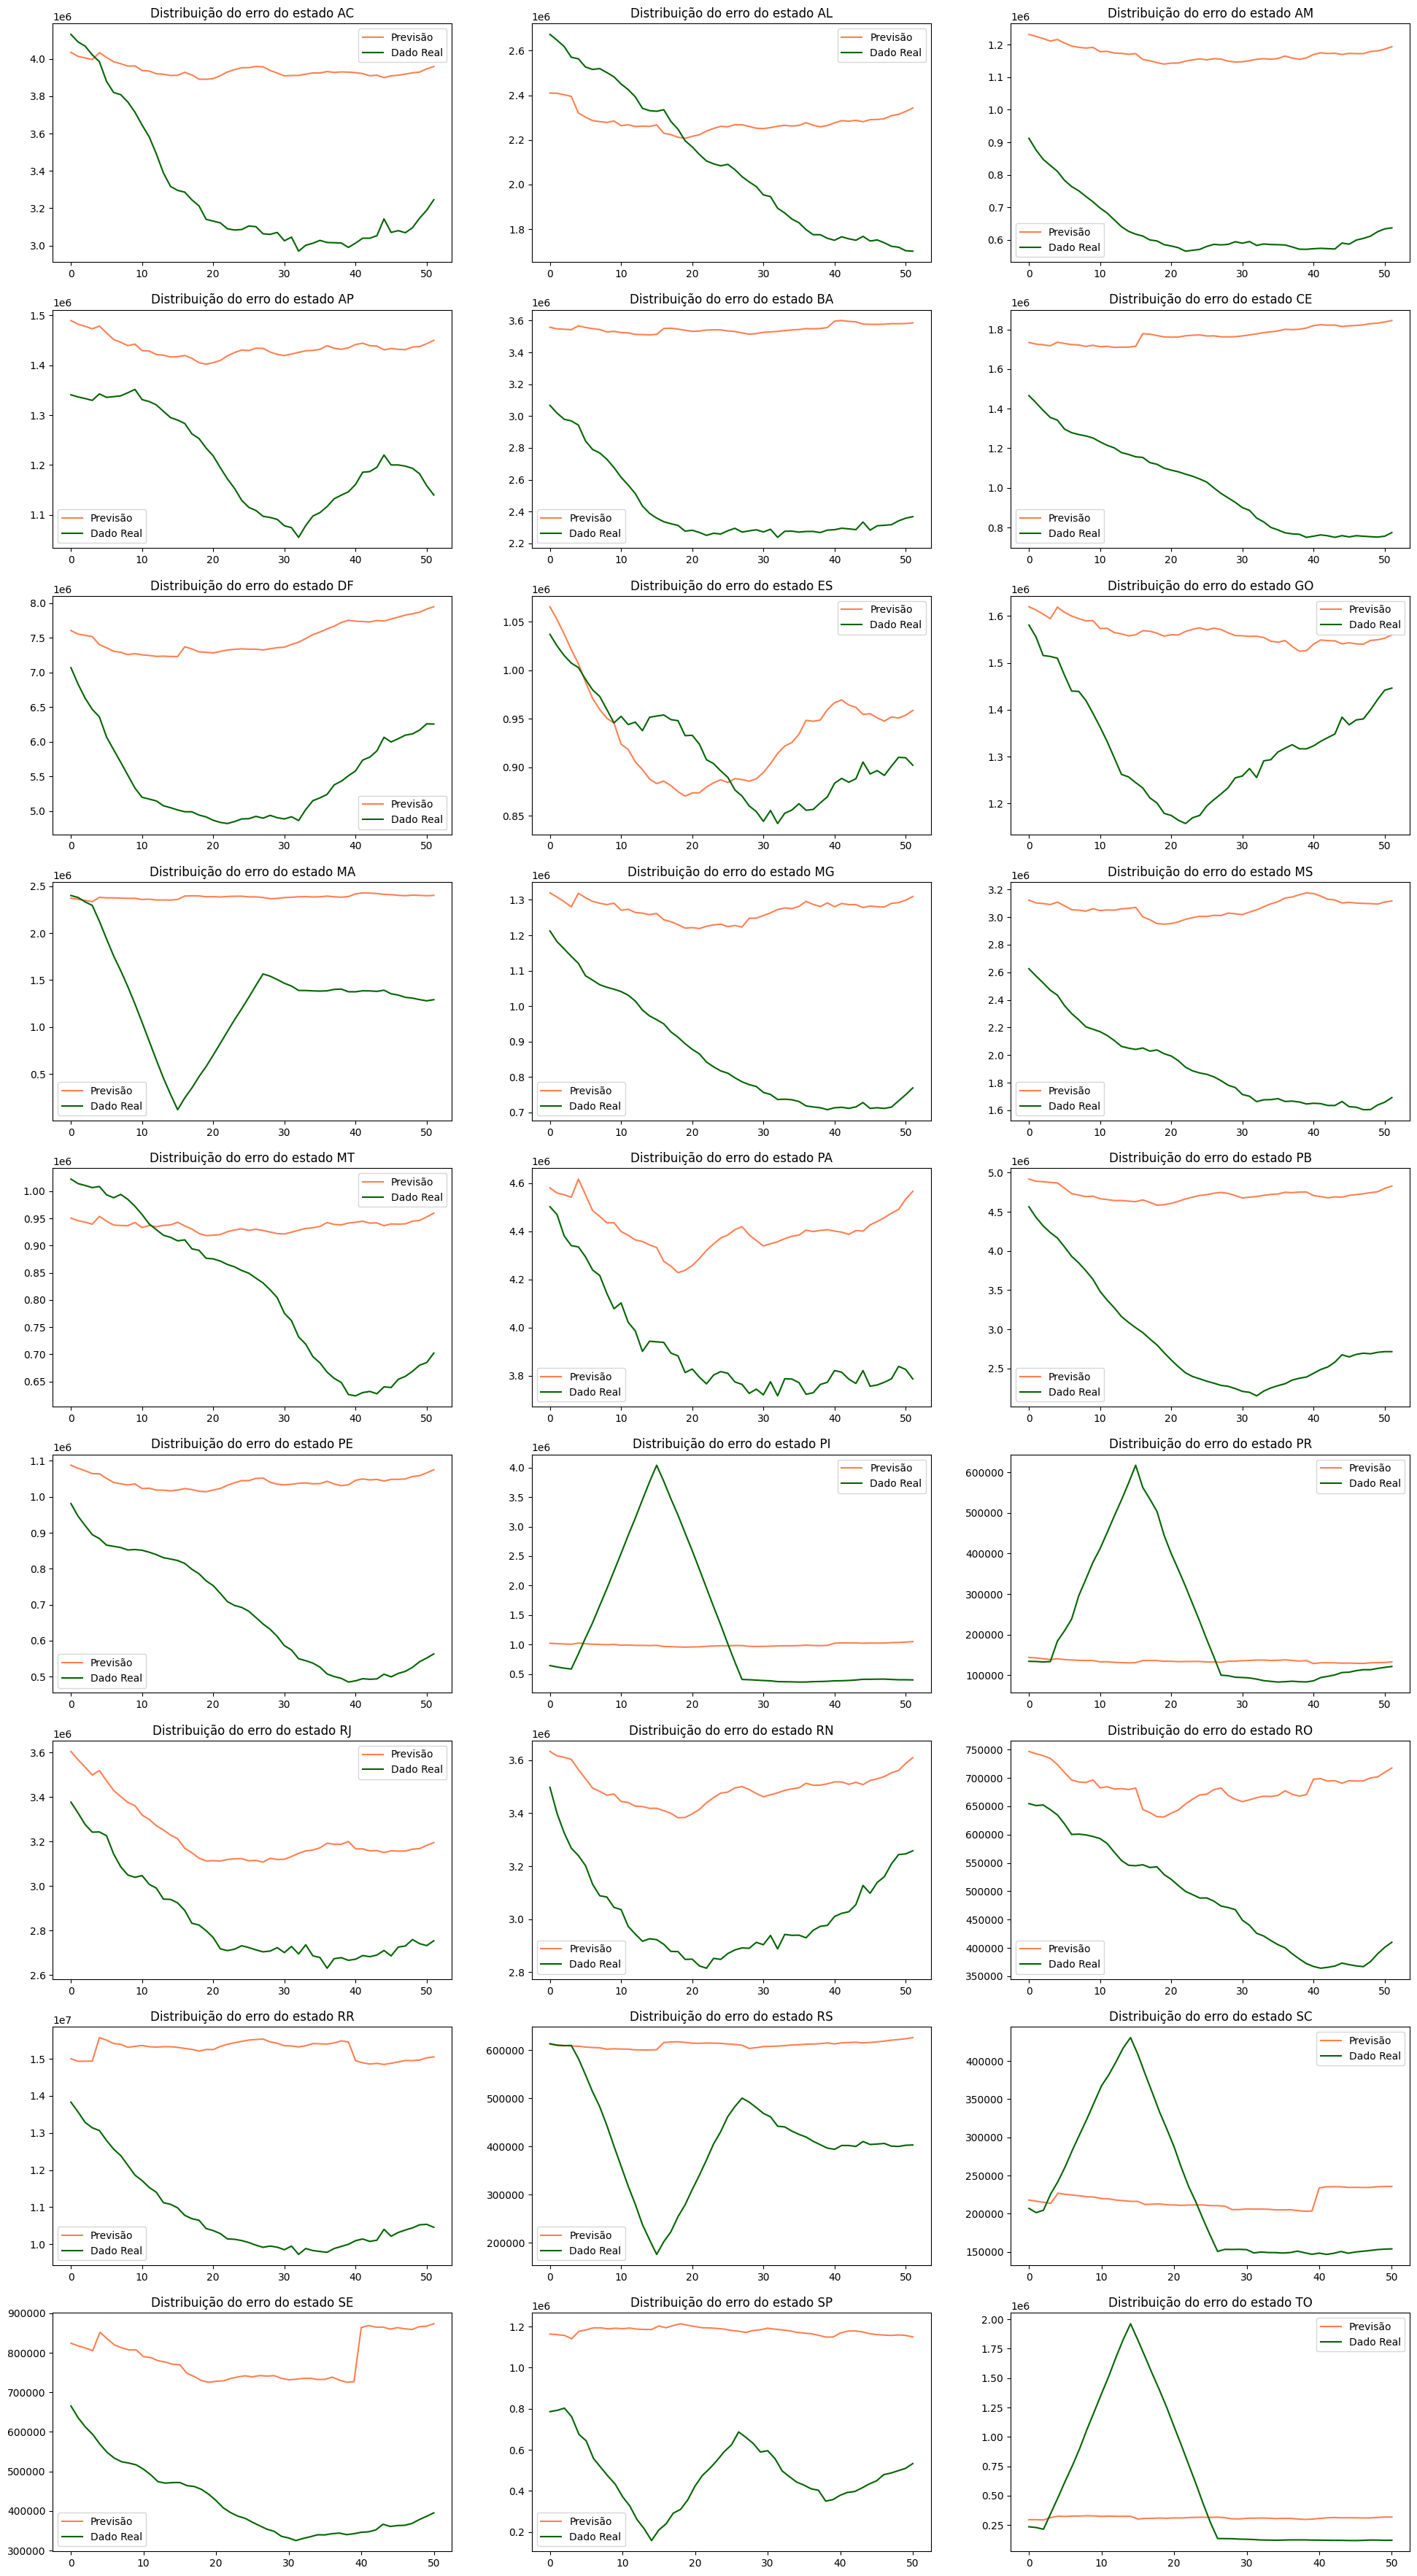

In [120]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [6]:
x = pd.read_csv(PATH+"input.csv")


HTTPError: HTTP Error 404: Not Found

<AxesSubplot: >

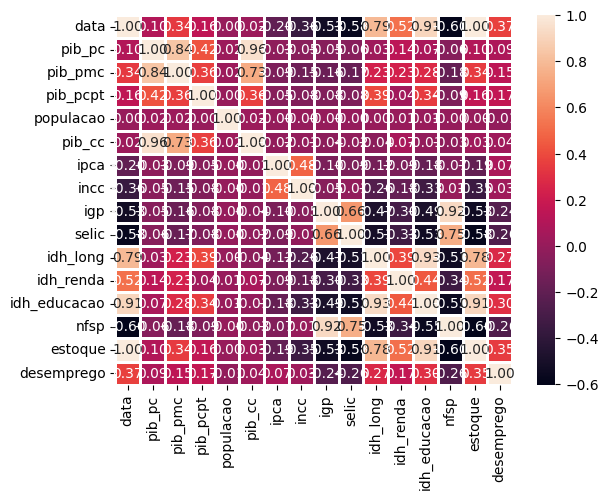

In [5]:
sns.heatmap(x.corr(), annot=True, fmt='.2f', linewidths=2)
